# 今日話すこと

- Juliaとは？

- Juliaの特徴的な機能

- Juliaのライブラリ (主にML)

# なぜ話そうと思ったか？

- 学生時代、数値計算をするのに良く使っていた

- 最近JuliaConというJuliaのカンファレンスを見てまた使ってみたくなった

# Julia とは？

- 「Pythonのように書けて，Cのように動く」が謳い文句の比較的新しいプログラミング言語

- そろそろJuliaが来ると言われてはや $n$ 年…

個人的には

- 良く考えなくても比較的早いコードが書ける

- 文法が直感的

という点で、アイディアを色々試すのに使いやすい言語だと思います

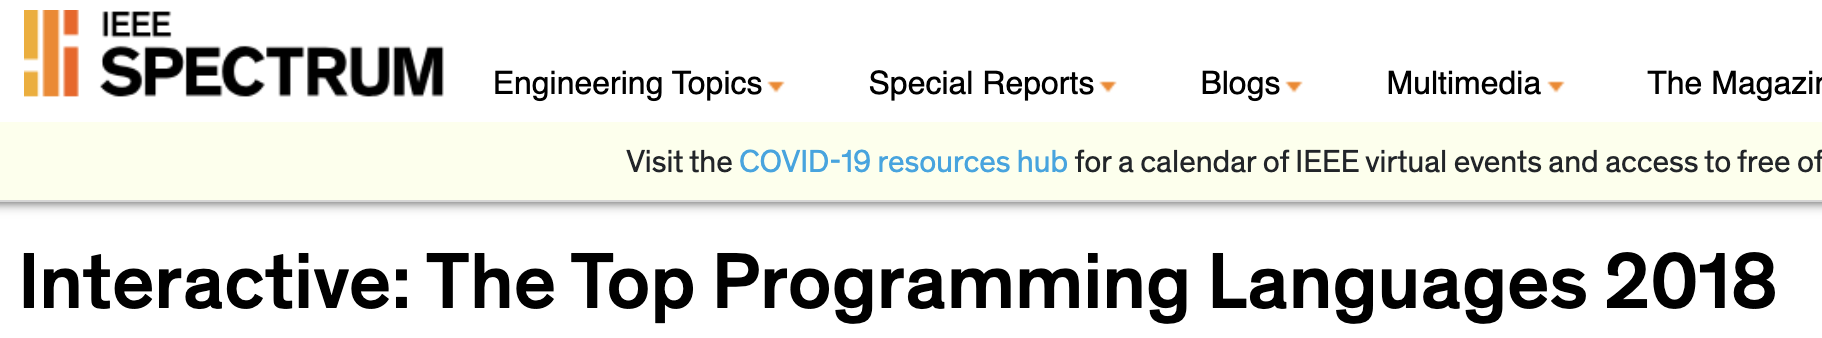

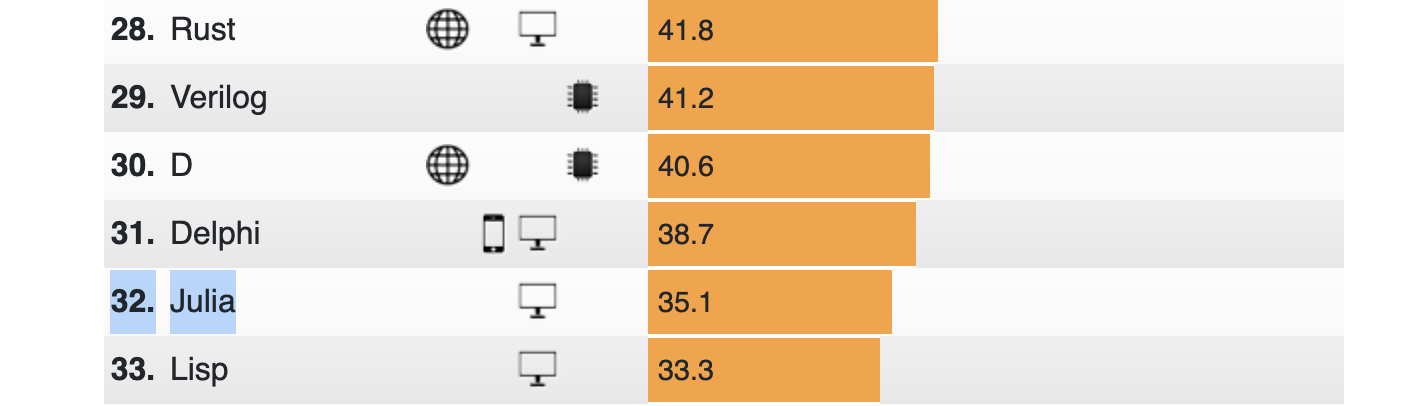

## 2020

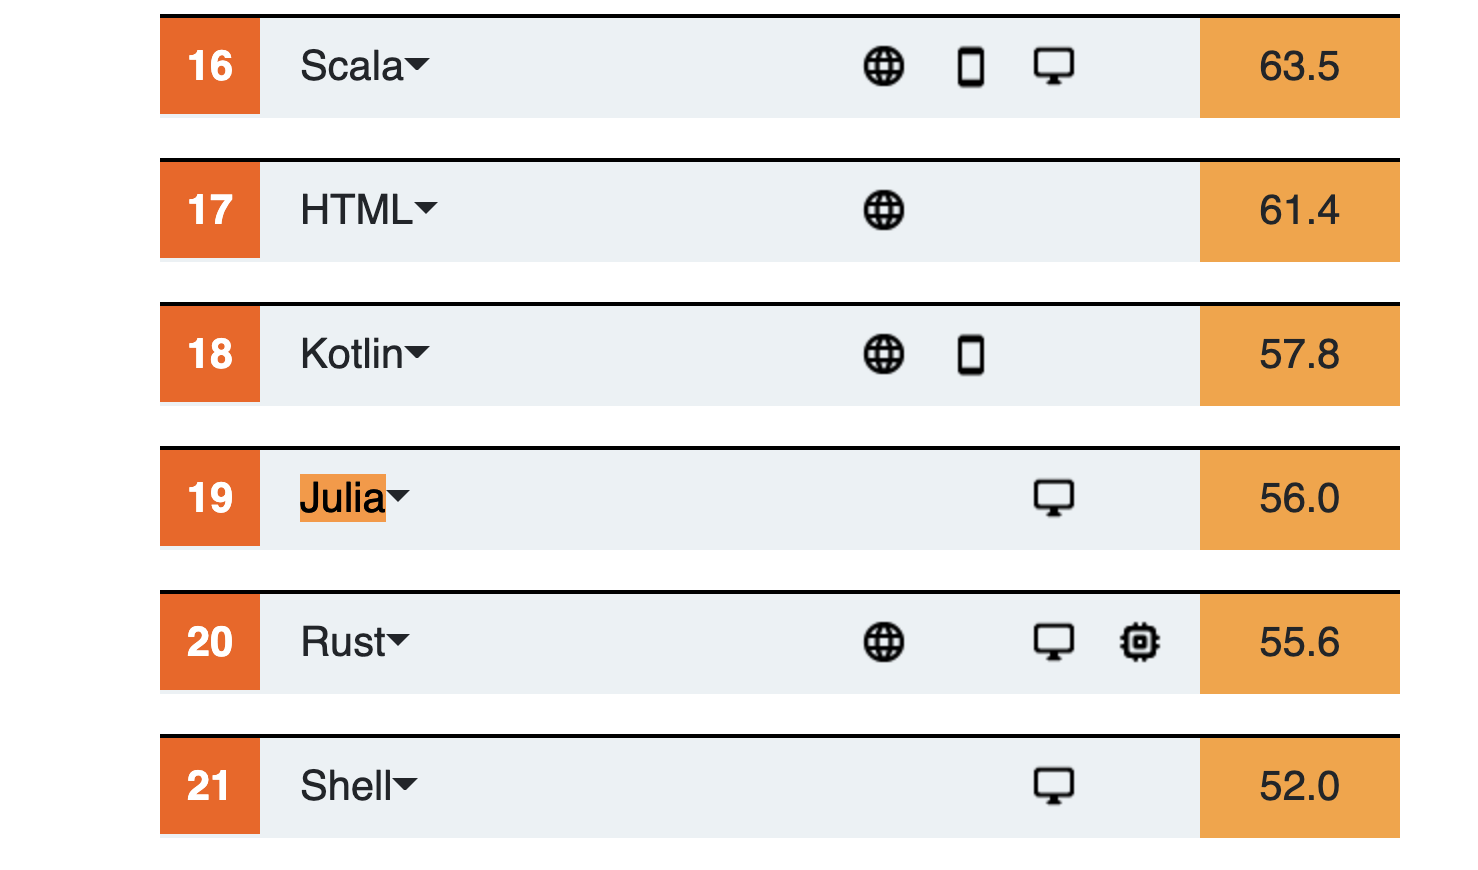

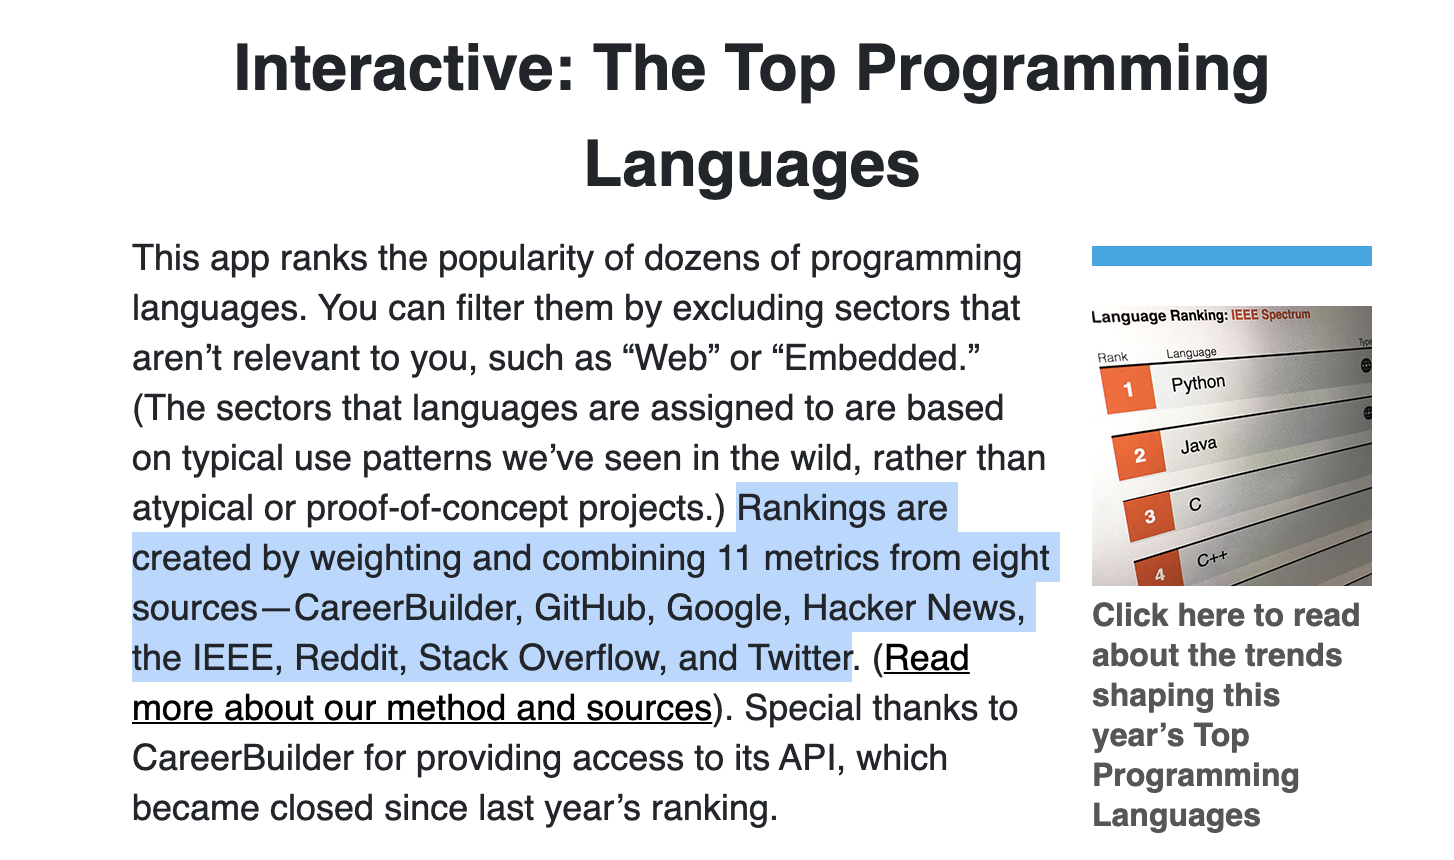

## Juliaの特徴

From official web page

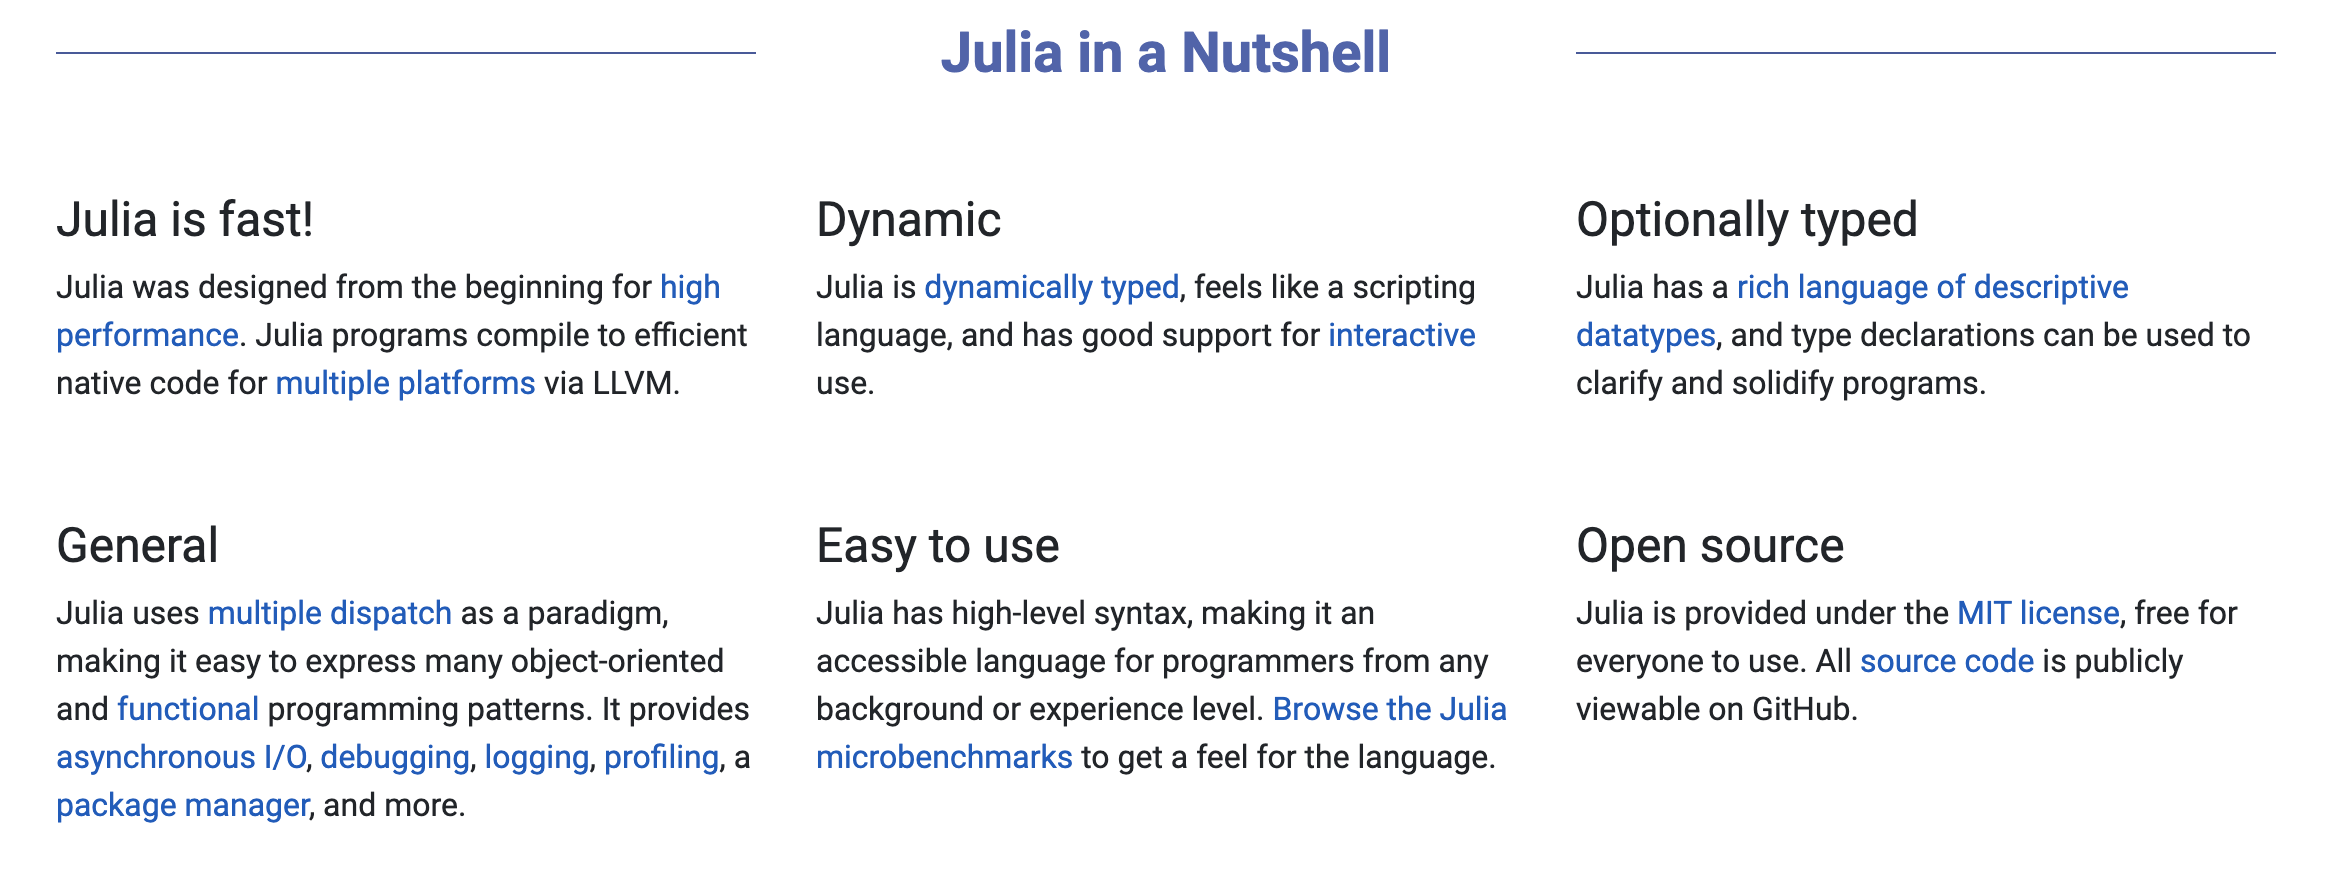

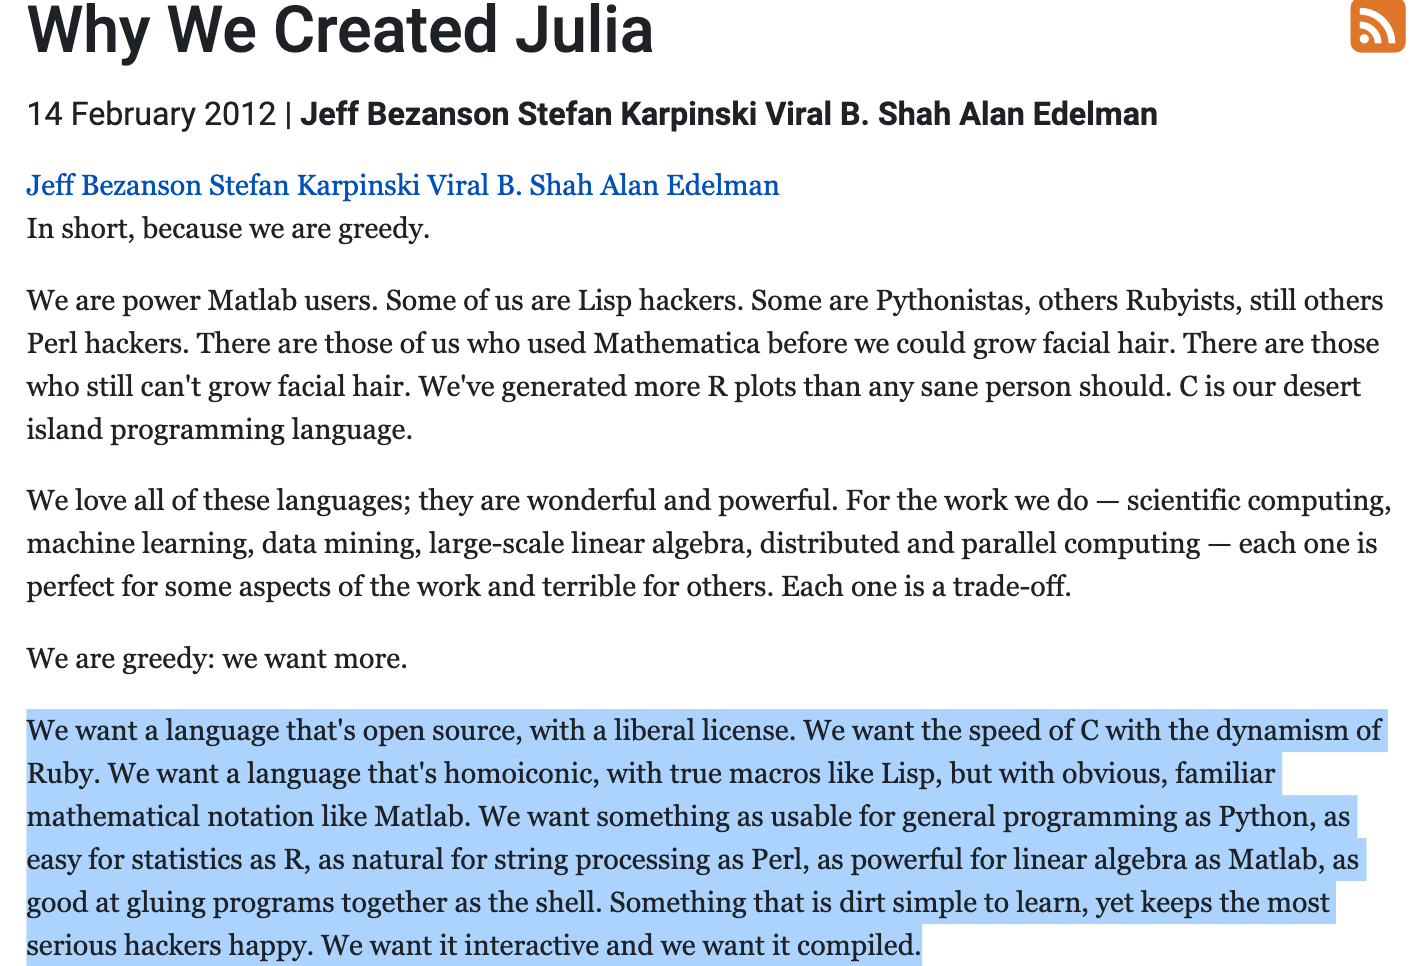

https://julialang.org/blog/2012/02/why-we-created-julia/#:~:text=We%20want%20something%20as%20usable,the%20most%20serious%20hackers%20happy.https://julialang.org/blog/2012/02/why-we-created-julia/#:~:text=We%20want%20something%20as%20usable,the%20most%20serious%20hackers%20happy.

https://julialang.org/

## Julia is fast?

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

### Built-in `sum`

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)
a

10000000-element Array{Float64,1}:
 0.49918287544966145
 0.8719196811706398
 0.44094212101192
 0.0033359775999253216
 0.9966967716632946
 0.8248726400416724
 0.5485607293908115
 0.5318561622013347
 0.7006500789599752
 0.23549636502939286
 0.028317791301014195
 0.8136333833426523
 0.041163582724630166
 ⋮
 0.38088295976365183
 0.34236997541338776
 0.32159691510997934
 0.22134977437732095
 0.4700017583882685
 0.12493960674231452
 0.48881052468122754
 0.4797303447598653
 0.21767704065974036
 0.9669744804021498
 0.04605694409596195
 0.04259413181940852

In [2]:
@time sum(a)

@time sum(a)

@time sum(a)

  0.034598 seconds (70.34 k allocations: 3.675 MiB)
  0.003954 seconds (1 allocation: 16 bytes)
  0.003773 seconds (1 allocation: 16 bytes)


5.000959311838584e6

In [3]:
using BenchmarkTools
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.053 ms (0.00% GC)
  median time:      4.442 ms (0.00% GC)
  mean time:        4.509 ms (0.00% GC)
  maximum time:     6.913 ms (0.00% GC)
  --------------
  samples:          1109
  evals/sample:     1

### Hand-written

In [5]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    return s
end

mysum (generic function with 1 method)

In [6]:
mysum(a)

5.000996678744701e6

In [7]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.553 ms (0.00% GC)
  median time:      10.336 ms (0.00% GC)
  mean time:        10.437 ms (0.00% GC)
  maximum time:     13.388 ms (0.00% GC)
  --------------
  samples:          479
  evals/sample:     1

In [8]:
d = Dict()
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 2 entries:
  "Julia hand-written" => 9.55338
  "Julia built-in"     => 4.00333

### C

In [9]:
using Libdl

C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file
# compile to a shared library by piping C_code to gcc
open(`gcc -std=c99 -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end
# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [10]:
c_sum(a)

5.000996678744701e6

In [11]:
c_sum(a) ≈ sum(a)


true

In [12]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.602 ms (0.00% GC)
  median time:      10.188 ms (0.00% GC)
  mean time:        10.261 ms (0.00% GC)
  maximum time:     13.272 ms (0.00% GC)
  --------------
  samples:          488
  evals/sample:     1

In [13]:
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 3 entries:
  "C"                  => 9.60215
  "Julia hand-written" => 9.55338
  "Julia built-in"     => 4.00333

## Numpy

In [14]:
using PyCall
using Conda

numpy_sum =  pyimport("numpy")."sum"
apy_numpy = PyObject(a) # converts to a numpy array by default

numpy_sum(apy_numpy) 

5.000996678744898e6

In [15]:
py_numpy_bench = @benchmark $numpy_sum($apy_numpy)

BenchmarkTools.Trial: 
  memory estimate:  32 bytes
  allocs estimate:  2
  --------------
  minimum time:     3.216 ms (0.00% GC)
  median time:      3.608 ms (0.00% GC)
  mean time:        3.706 ms (0.00% GC)
  maximum time:     8.319 ms (0.00% GC)
  --------------
  samples:          1349
  evals/sample:     1

In [16]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                  => 9.60215
  "Julia hand-written" => 9.55338
  "Python numpy"       => 3.21568
  "Julia built-in"     => 4.00333

# Julia の特徴的な機能

## Broadcasting

Numpyのように暗黙のbroadcastはない

In [97]:
A = rand(2, 3)

2×3 Array{Float64,2}:
 0.248135  0.533436  0.639012
 0.631851  0.248055  0.12179

In [18]:
A + 1

LoadError: MethodError: no method matching +(::Array{Float64,2}, ::Int64)
For element-wise addition, use broadcasting with dot syntax: array .+ scalar
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:538
  +(!Matched::PyObject, ::Any) at /Users/keisuke.yanagi/.julia/packages/PyCall/zqDXB/src/pyoperators.jl:13
  +(!Matched::Missing, ::Number) at missing.jl:115
  ...

In [85]:
A .+ 1

3×3 Array{Float64,2}:
 1.18426  1.98882  1.48963
 1.11933  1.58374  1.28666
 1.17652  1.27421  1.66595

In [86]:
exp(1.4)

4.0551999668446745

In [90]:
exp.(A) .+ log.(A) 

3×3 Array{Float64,2}:
 -0.489078  2.67683    0.917592
 -0.999093  1.25444    0.0825347
 -0.541287  0.0216277  1.5398

式にドット (.) をつけるだけなので簡単だし、式が見やすい

## Multiple dispatch

- 同じ名前で引数の型が異なる関数を定義する機能

- C++のオーバーロードに似ているが、Juliaの場合は実行時に動的に行われる

In [21]:
f(x::Float64, y::Float64) = 2x + y

f(x::Int64, y::Int64) = 2x - y

f(x::String) = print(x)

f() = print("Hello world!") 

f (generic function with 4 methods)

In [22]:
f(2.0, 3.0)

7.0

In [23]:
f(2, 3)

1

In [24]:
f("ZOZOTOWN")

ZOZOTOWN

In [25]:
f()

Hello world!

型が合わないとエラーになる

In [26]:
f(2.0, 3)

LoadError: MethodError: no method matching f(::Float64, ::Int64)
Closest candidates are:
  f(!Matched::Int64, ::Int64) at In[21]:3
  f(::Float64, !Matched::Float64) at In[21]:1

In [27]:
methods(f)

# 4 methods for generic function "f":
[1] f() in Main at In[21]:7
[2] f(x::String) in Main at In[21]:5
[3] f(x::Int64, y::Int64) in Main at In[21]:3
[4] f(x::Float64, y::Float64) in Main at In[21]:1

- Julia に class はない (struct はある)

- クラスを作ってオブジェクトに関数を所有させることはできない

- multiple dispatch を利用することで、オブジェクトの型に応じたメソッドを定義できる

In [28]:
methods(+)

# 188 methods for generic function "+":
[1] +(x::Dates.Date, y::Dates.Day) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/arithmetic.jl:74
[2] +(x::Dates.Date, y::Dates.Week) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/arithmetic.jl:72
[3] +(dt::Dates.Date, z::Dates.Month) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/arithmetic.jl:54
[4] +(dt::Dates.Date, y::Dates.Year) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/arithmetic.jl:27
[5] +(dt::Dates.Date, t::Dates.Time) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/arithmetic.jl:19
[6] +(a::PyObject, b::PyObject) in PyCall at /Users/keisuke.yanagi/.julia/packages/PyCall/zqDXB/src/pyoperators.jl:11
[7] +(a::PyObject) in PyCall at /Users/keisuke.yanagi/.julia/packages/PyCall/zqDXB/src/pyoperators.jl:41
[8] +(a::PyObject, b) in PyCall at /Users/keisuke.yanagi/.julia/packages/PyCall/zqDXB/src/pyoperators.jl:13
[9] +(a::Float16, b::Float16) in Base at float.jl:398
[10] +(::Missing, ::Missing) in Base at missing.jl:114
[11] +(::Missing) in Base at missing.jl:100
[12] +(::Missing, ::Number) in Base at missing.jl:115
[13] +(t::Dates.Time, dt::Dates.Date) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/arithmetic.jl:20
[14] +(x::Dates.Time, y::Dates.TimePeriod) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/arithmetic.jl:78
[15] +(x::Float32, y::Float32) in Base at float.jl:400
[16] +(a::Pkg.Resolve.FieldValue, b::Pkg.Resolve.FieldValue) in Pkg.Resolve at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Pkg/src/Resolve/fieldvalues.jl:43
[17] +(x::Bool, z::Complex{Bool}) in Base at complex.jl:286
[18] +(x::Bool, y::Bool) in Base at bool.jl:96
[19] +(x::Bool) in Base at bool.jl:93
[20] +(x::Bool, y::T) where T<:AbstractFloat in Base at bool.jl:103
[21] +(x::Bool, z::Complex) in Base at complex.jl:293
[22] +(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat, e::BigFloat) in Base.MPFR at mpfr.jl:548
[23] +(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat) in Base.MPFR at mpfr.jl:541
[24] +(a::BigFloat, b::BigFloat, c::BigFloat) in Base.MPFR at mpfr.jl:535
[25] +(x::BigFloat, c::BigInt) in Base.MPFR at mpfr.jl:394
[26] +(x::BigFloat, y::BigFloat) in Base.MPFR at mpfr.jl:363
[27] +(x::BigFloat, c::Union{UInt16, UInt32, UInt64, UInt8}) in Base.MPFR at mpfr.jl:370
[28] +(x::BigFloat, c::Union{Int16, Int32, Int64, Int8}) in Base.MPFR at mpfr.jl:378
[29] +(x::BigFloat, c::Union{Float16, Float32, Float64}) in Base.MPFR at mpfr.jl:386
[30] +(level::Base.CoreLogging.LogLevel, inc::Integer) in Base.CoreLogging at logging.jl:116
[31] +(z::Complex{Bool}, x::Bool) in Base at complex.jl:287
[32] +(z::Complex{Bool}, x::Real) in Base at complex.jl:301
[33] +(x::Float64, y::Float64) in Base at float.jl:401
[34] +(x::Dates.CompoundPeriod, y::Dates.CompoundPeriod) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/periods.jl:347
[35] +(x::Dates.CompoundPeriod, y::Dates.Period) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/periods.jl:345
[36] +(x::Dates.CompoundPeriod, y::Dates.TimeType) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/periods.jl:375
[37] +(dt::Dates.DateTime, z::Dates.Month) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/arithmetic.jl:47
[38] +(dt::Dates.DateTime, y::Dates.Year) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/share/julia/stdlib/v1.5/Dates/src/arithmetic.jl:23
[39] +(x::Dates.DateTime, y::Dates.Period) in Dates at /Applications/Julia-1.5.app/Contents/Resources/julia/sh

例

In [29]:
struct Vector2D
    x::Float64
    y::Float64
end

In [30]:
import Base.+
+(u::Vector2D, v::Vector2D) = Vector2D(u.x + v.x, u.y + v.y) 

+ (generic function with 189 methods)

In [31]:
u = Vector2D(0, 1); v = Vector2D(1, 0)
u + v

Vector2D(1.0, 1.0)

別の例

In [32]:
mutable struct Linear_model
    # model for y = ax + b
    a::Float64
    b::Float64
end

In [33]:
function fit(model::Linear_model, x1::Float64, y1::Float64, x2::Float64, y2::Float64)
    if x1 != x2
        a = (y2 - y1) / (x2 - x1)
        b = y1 - a * x1
        model.a = a
        model.b = b　
    end
end

fit (generic function with 1 method)

In [34]:
model = Linear_model(0.0, 0.0)
model.a, model.b

(0.0, 0.0)

In [35]:
fit(model, 1., 4., 3., -7.)
model.a, model.b

(-5.5, 9.5)

他言語の `model.fit(...)` はJuliaでは `fit(model, ...)` のようになる

multiple dispatch を使うことで様々な同名のメソッドを作成できる

In [36]:
function fit(model::Linear_model, xs::Array{Float64, 1}, ys::Array{Float64, 1})
    # least square
    X = ones(length(xs), 2)
    X[:,2] = xs
    b, a = inv(X' * X) * X' * ys
    model.a = a
    model.b = b 
end

fit (generic function with 2 methods)

In [37]:
xs = rand(100)
ys = 2 .* xs .+ 1 .+ randn(); # a=2, b=1

In [38]:
fit(model, xs, ys)
model.a, model.b

(1.999999999999997, 2.010584281540892)

## Metaprogramming

- Julia はメタプログラミングを比較的多用する

- プログラムを使ってプログラムを生成する

例えば、以下のような変数を生成するコードが書ける

In [39]:
# var_A, var_B, var_C という変数を一度に作る
for (suffix, value) in zip((:A, :B, :C), (1, 2, 3))
    eval(:($(Symbol(:var_, suffix)) = $(value)))
end

In [40]:
var_A, var_B, var_C

(1, 2, 3)

「マクロ」がよく出てくる。

例えば先ほど使った時間測定用の `@benchmark`

In [41]:
@benchmark sum(a)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     3.937 ms (0.00% GC)
  median time:      4.320 ms (0.00% GC)
  mean time:        4.404 ms (0.00% GC)
  maximum time:     9.268 ms (0.00% GC)
  --------------
  samples:          1135
  evals/sample:     1

ライブラリ独自の文法を簡単に実装できるので良く使われる

# ライブラリ

データサイエンスのためのライブラリ

- DataFrames.jl : データフレームを扱う

- MLJ.jl : MLの toolkit (scikit-learn のようなもの)

- JuliaStats : 統計ツールのライブラリ集 (Rっぽい)

- Flux.jl : Deep learning

- Gen.jl, Turing.jl : Probabilistic programming

- Plots.jl, PyPlot.jl : 可視化ツール

## DataFrames.jl

データフレームを扱うライブラリ (pandasのようなもの)

Kaggle の titanic コンペのテーブルを読み込んでみる

In [4]:
using DataFrames
using CSV

In [5]:
df_train = CSV.read("titanic/train.csv");
df_test = CSV.read("titanic/test.csv");
df_gender_sub = CSV.read("titanic/gender_submission.csv");

In [44]:
first(df_train, 5)

,PassengerId,Survived,Pclass,Name
,Int64,Int64,Int64,String
1,1,0,3,"Braund, Mr. Owen Harris"
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)"
3,3,1,3,"Heikkinen, Miss. Laina"
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
5,5,0,3,"Allen, Mr. William Henry"


In [45]:
names(df_train)

12-element Array{String,1}:
 "PassengerId"
 "Survived"
 "Pclass"
 "Name"
 "Sex"
 "Age"
 "SibSp"
 "Parch"
 "Ticket"
 "Fare"
 "Cabin"
 "Embarked"

データの前処理

In [46]:
drop_cols = [:Name, :Ticket, :Cabin, :Embarked]
df_train = df_train[Not(drop_cols)]
df_test = df_test[Not(drop_cols)]
describe(df_train)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,Type
1,PassengerId,446.0,1,446.0,891,,,Int64
2,Survived,0.383838,0,0.0,1,,,Int64
3,Pclass,2.30864,1,3.0,3,,,Int64
4,Sex,,female,,male,2,,String
5,Age,29.6991,0.42,28.0,80.0,,177,"Union{Missing, Float64}"
6,SibSp,0.523008,0,0.0,8,,,Int64
7,Parch,0.381594,0,0.0,6,,,Int64
8,Fare,32.2042,0.0,14.4542,512.329,,,Float64


Data frameの操作に便利なマクロがある

In [6]:
using DataFramesMeta

In [48]:
mean_train_age = mean(dropmissing(df_train, :Age).Age)

df_train = @linq df_train |>
    transform(Age = ifelse.(ismissing.(:Age), mean_train_age, :Age)) |>
    transform(Sex = ifelse.(:Sex .== "male", 0, 1))

df_test = @linq df_test |>
    transform(Age = ifelse.(ismissing.(:Age), mean_train_age, :Age)) |>
    transform(Sex = ifelse.(:Sex .== "male", 0, 1));

## MLJ.jl

- MLJ は python における scikit-learn のような立ち位置のライブラリ

- scientific typeという、MLにおける役割を表す型を付与するのが特徴

- Model の ensemble をやりやすいような作りになっている

In [7]:
using MLJ

In [50]:
schema(df_train)

┌─────────────┬─────────┬────────────┐
│ _.names     │ _.types │ _.scitypes │
├─────────────┼─────────┼────────────┤
│ PassengerId │ Int64   │ Count      │
│ Survived    │ Int64   │ Count      │
│ Pclass      │ Int64   │ Count      │
│ Sex         │ Int64   │ Count      │
│ Age         │ Float64 │ Continuous │
│ SibSp       │ Int64   │ Count      │
│ Parch       │ Int64   │ Count      │
│ Fare        │ Float64 │ Continuous │
└─────────────┴─────────┴────────────┘
_.nrows = 891


カテゴリ変数の`Survived`に`Count`がついてしまっているため、`Multiclass`に修正する

In [51]:
coerce!(df_train, :Survived=>Multiclass);
coerce!(df_test, :Survived=>Multiclass);

schema(df_train)

┌─────────────┬────────────────────────────────┬───────────────┐
│ _.names     │ _.types                        │ _.scitypes    │
├─────────────┼────────────────────────────────┼───────────────┤
│ PassengerId │ Int64                          │ Count         │
│ Survived    │ CategoricalValue{Int64,UInt32} │ Multiclass{2} │
│ Pclass      │ Int64                          │ Count         │
│ Sex         │ Int64                          │ Count         │
│ Age         │ Float64                        │ Continuous    │
│ SibSp       │ Int64                          │ Count         │
│ Parch       │ Int64                          │ Count         │
│ Fare        │ Float64                        │ Continuous    │
└─────────────┴────────────────────────────────┴───────────────┘
_.nrows = 891


In [52]:
y, X = unpack(df_train[Not(:PassengerId)], ==(:Survived), colname -> true);

モデルのロード

In [53]:
tree_model = @load DecisionTreeClassifier

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @ 1…80

In [54]:
tree = machine(tree_model, X, y)

Machine{DecisionTreeClassifier} @ 1…75


モデルの学習と評価

In [55]:
evaluate!(tree, resampling=CV(nfolds=3, shuffle=true), measure=accuracy, operation=predict_mode, verbosity=1)

Evaluating over 3 folds: 100%[=========================] Time: 0:00:05


┌───────────┬───────────────┬───────────────────────┐
│ _.measure │ _.measurement │ _.per_fold            │
├───────────┼───────────────┼───────────────────────┤
│ accuracy  │ 0.773         │ [0.788, 0.785, 0.747] │
└───────────┴───────────────┴───────────────────────┘
_.per_observation = [missing]


### Model tuning

In [56]:
r_depth = range(DecisionTreeClassifier(), :max_depth, lower=1, upper=10)
r_leaf = range(DecisionTreeClassifier(), :min_samples_leaf, lower=1, upper=10)
r_split = range(DecisionTreeClassifier(), :min_samples_split, lower=2, upper=10)

ranges = [r_depth, r_leaf, r_split]

3-element Array{MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol},1}:
 MLJBase.NumericRange(Int64, :max_depth, ... )
 MLJBase.NumericRange(Int64, :min_samples_leaf, ... )
 MLJBase.NumericRange(Int64, :min_samples_split, ... )

In [57]:
tuned_tree = TunedModel(model=DecisionTreeClassifier(), 
                                            ranges=ranges,
                                            measure=accuracy,
                                            resampling=CV(nfolds=3, shuffle=true),
                                            operation=predict_mode)

ProbabilisticTunedModel(
    model = DecisionTreeClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            post_prune = false,
            merge_purity_threshold = 1.0,
            pdf_smoothing = 0.0,
            display_depth = 5),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 3,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict_mode,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @ 1…05, NumericRange{Int64,…} @ 7…21, NumericRange{Int64,…} @ 1…51],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPU1{Nothing}(nothing),
    acceleration_resamp

In [58]:
tuned_tree_model = machine(tuned_tree, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @ 1…32


In [59]:
fit!(tuned_tree_model)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @ 1…32.
└ @ MLJBase /Users/keisuke.yanagi/.julia/packages/MLJBase/8HOpr/src/machines.jl:187
┌ Info: Attempting to evaluate 900 models.
└ @ MLJTuning /Users/keisuke.yanagi/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 900 metamodels: 100%[=========================] Time: 0:00:04


Machine{ProbabilisticTunedModel{Grid,…}} @ 1…32


In [60]:
r = report(tuned_tree_model);

In [61]:
r.history

900-element Array{Tuple{DecisionTreeClassifier,NamedTuple{(:measure, :measurement),Tuple{Array{MLJBase.Accuracy,1},Array{Float64,1}}}},1}:
 (DecisionTreeClassifier @ 8…68, (measure = [accuracy], measurement = [0.7946127946127947]))
 (DecisionTreeClassifier @ 1…94, (measure = [accuracy], measurement = [0.8103254769921436]))
 (DecisionTreeClassifier @ 2…19, (measure = [accuracy], measurement = [0.8080808080808081]))
 (DecisionTreeClassifier @ 1…63, (measure = [accuracy], measurement = [0.8159371492704826]))
 (DecisionTreeClassifier @ 9…56, (measure = [accuracy], measurement = [0.7833894500561168]))
 (DecisionTreeClassifier @ 1…54, (measure = [accuracy], measurement = [0.8047138047138048]))
 (DecisionTreeClassifier @ 1…45, (measure = [accuracy], measurement = [0.8114478114478114]))
 (DecisionTreeClassifier @ 3…21, (measure = [accuracy], measurement = [0.797979797979798]))
 (DecisionTreeClassifier @ 8…05, (measure = [accuracy], measurement = [0.7934904601571269]))
 (DecisionTreeClassifier 

In [62]:
r.best_result

(measure = [accuracy],
 measurement = [0.8316498316498316],)

In [63]:
r.best_model

DecisionTreeClassifier(
    max_depth = 7,
    min_samples_leaf = 6,
    min_samples_split = 6,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @ 8…88

テストデータに対する予測

In [64]:
df_test = @linq df_test |>
    transform(Fare = ifelse.(ismissing.(:Fare), mean(df_train.Fare), :Fare));

In [65]:
ypreds =  predict_mode(tuned_tree_model, df_test[Not(:PassengerId)]);

In [66]:
df_sub_tree = DataFrame()
df_sub_tree.PassengerId = df_test.PassengerId
df_sub_tree.Survived = ypreds
first(df_sub_tree, 5)

,PassengerId,Survived
,Int64,Cat…
1,892,0
2,893,0
3,894,0
4,895,0
5,896,1


In [67]:
CSV.write("titanic/tree_submission.csv", df_sub_tree)

"titanic/tree_submission.csv"

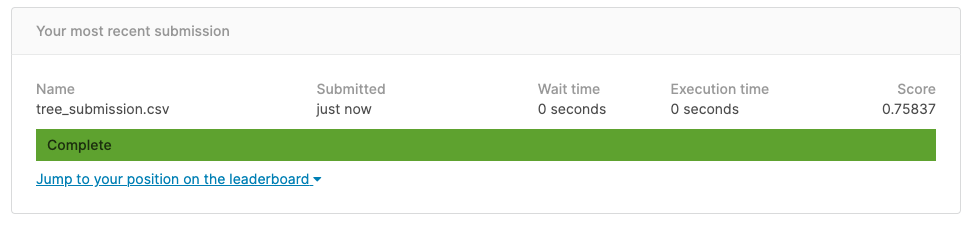

### Model ensemble

In [68]:
forest = EnsembleModel(atom=DecisionTreeClassifier())

ProbabilisticEnsembleModel(
    atom = DecisionTreeClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            post_prune = false,
            merge_purity_threshold = 1.0,
            pdf_smoothing = 0.0,
            display_depth = 5),
    atomic_weights = Float64[],
    bagging_fraction = 0.8,
    rng = Random._GLOBAL_RNG(),
    n = 100,
    acceleration = CPU1{Nothing}(nothing),
    out_of_bag_measure = Any[]) @ 1…21

In [69]:
r_depth = range(forest, :(atom.max_depth), lower=5, upper=20)
r_leaf = range(forest, :(atom.min_samples_leaf), lower=2, upper=5)
r_split = range(forest, :(atom.min_samples_split), lower=2, upper=5)
r_purity = range(forest, :(atom.min_purity_increase), lower=0.0, upper=1.0)
r_bf = range(forest, :bagging_fraction, lower=0.5, upper=1.0);

ranges = [r_depth, r_leaf, r_split, r_purity, r_bf];

In [70]:
tuned_forest = TunedModel(model=forest, 
                                            tuning=Grid(resolution=4),
                                            ranges=ranges,
                                            measure=accuracy,
                                            resampling=CV(nfolds=3, shuffle=true),
                                            operation=predict_mode)

ProbabilisticTunedModel(
    model = ProbabilisticEnsembleModel(
            atom = DecisionTreeClassifier @ 1…54,
            atomic_weights = Float64[],
            bagging_fraction = 0.8,
            rng = Random._GLOBAL_RNG(),
            n = 100,
            acceleration = CPU1{Nothing}(nothing),
            out_of_bag_measure = Any[]),
    tuning = Grid(
            goal = nothing,
            resolution = 4,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 3,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict_mode,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @ 9…20, NumericRange{Int64,…} @ 4…81, NumericRange{Int64,…} @ 2…34, NumericRange{Float64,…} @ 1…52, NumericRange{Float64,…} @ 1…68],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPU

In [71]:
tuned_forest_model = machine(tuned_forest, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @ 1…68


In [72]:
fit!(tuned_forest_model)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @ 1…68.
└ @ MLJBase /Users/keisuke.yanagi/.julia/packages/MLJBase/8HOpr/src/machines.jl:187
┌ Info: Attempting to evaluate 1024 models.
└ @ MLJTuning /Users/keisuke.yanagi/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 1024 metamodels: 100%[=========================] Time: 0:11:39


Machine{ProbabilisticTunedModel{Grid,…}} @ 1…68


In [73]:
r_forest = report(tuned_forest_model);
r_forest.best_result

(measure = [accuracy],
 measurement = [0.8451178451178452],)

In [74]:
r_forest.best_model

ProbabilisticEnsembleModel(
    atom = DecisionTreeClassifier(
            max_depth = 10,
            min_samples_leaf = 4,
            min_samples_split = 4,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            post_prune = false,
            merge_purity_threshold = 1.0,
            pdf_smoothing = 0.0,
            display_depth = 5),
    atomic_weights = Float64[],
    bagging_fraction = 0.6666666666666666,
    rng = Random._GLOBAL_RNG(),
    n = 100,
    acceleration = CPU1{Nothing}(nothing),
    out_of_bag_measure = Any[]) @ 4…16

In [75]:
ypreds_forest =  predict_mode(tuned_forest_model, df_test[Not(:PassengerId)]);

df_sub_forest = DataFrame()
df_sub_forest.PassengerId = df_test.PassengerId
df_sub_forest.Survived = ypreds_forest

CSV.write("titanic/forest_submission.csv", df_sub_forest)

"titanic/forest_submission.csv"

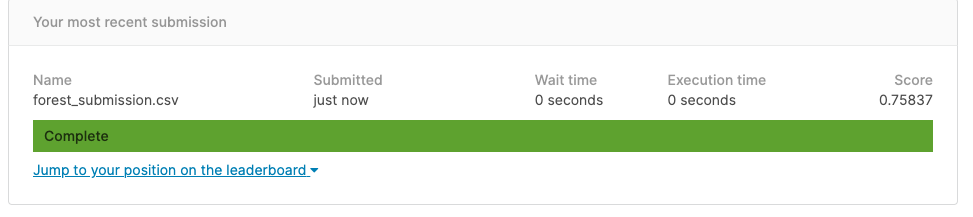

変わらない…？

## Flux.jl

- Deep learningのライブラリ

- GPUも使える

## Gen.jl, Turing.jl

- Probabilistic programmingのライブラリ

- 違いは知りません…

## DifferentialEquations.jl

- 微分方程式を数値的に解くための solver 集

- 学生時代の研究で良く使っていた

- おそらく界隈の中で最も充実している

## Web関係のライブラリ

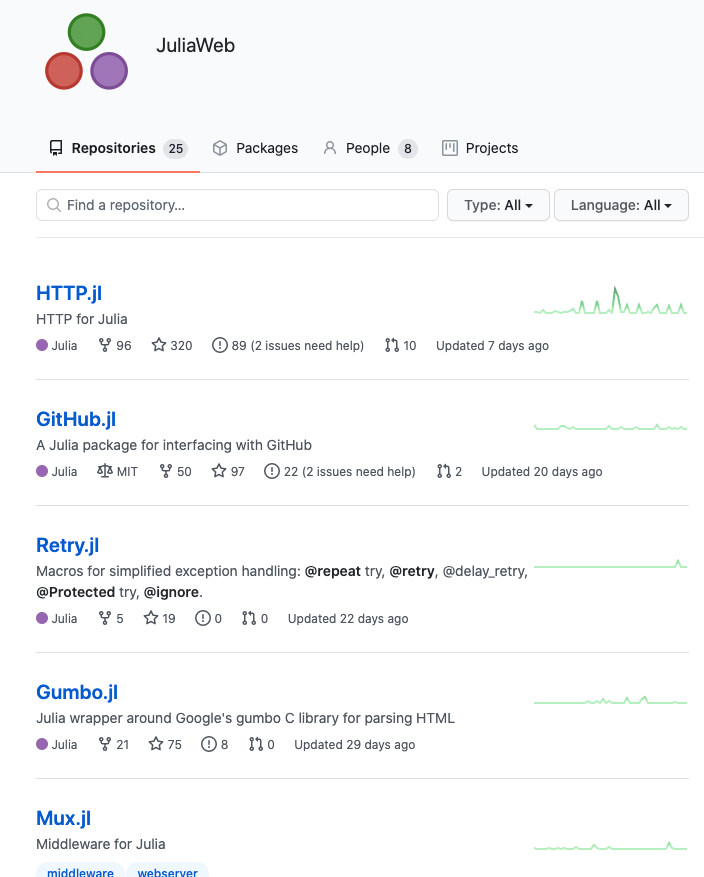

https://github.com/JuliaWeb

# まとめ

- 「Pythonのように書けて，Cのように動く」 Julia 

- 最近はエコシステムも成長してきているよう

- ぜひ使って（僕に色々教えて）ください